In [1]:
from random import random, uniform
from matplotlib import pyplot as plt
import numpy as np
import math
from tqdm import tqdm

In [2]:
from calc import distance, intersection, parallel, angle, orthogonal
from draw import draw
from line import Line
from plane import Plane
from point import Point
from solver import solve
from vector import Vector

__all__ = (
    "Line",
    "Plane",
    "Point",
    "Vector",
    "angle",
    "distance",
    "draw",
    "intersection",
    "orthogonal",
    "parallel",
    "solve",
)

In [3]:
class Cube():
    #куб с вершиной А в нуле координат и заданной длиной ребра, находится в первой полуплоскости для каждй пары осей
    def __init__(self, side=1, center=Point(0.5, 0.5, 0.5), ax3d=None):
        
        
        self.side = side
        self.center = center
        a = side
        
        vec = Point(center - Point(side/2, side/2, side/2))
        
        self.A = Point(0, 0, 0) + vec
        self.B = Point(a, 0, 0) + vec
        self.C = Point(a, a, 0) + vec
        self.D = Point(0, a, 0) + vec
        self.E = Point(0, 0, a) + vec
        self.F = Point(a, 0, a) + vec
        self.G = Point(a, a, a) + vec
        self.H = Point(0, a, a) + vec
        
        self.iterable_points = [self.A, self.B, self.C, self.D, self.E, self.F, self.G, self.H]
        self.names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
        
        self.AB = Line(self.A, self.B)
        self.BC = Line(self.B, self.C)
        self.AD = Line(self.A, self.D)
        self.DC = Line(self.D, self.C)
        
        self.AE = Line(self.A, self.E)
        self.BF = Line(self.B, self.F)
        self.CG = Line(self.C, self.G)
        self.DH = Line(self.D, self.H)
        
        self.EF = Line(self.E, self.F)
        self.EH = Line(self.E, self.H)
        self.FG = Line(self.F, self.G)
        self.HG = Line(self.H, self.G)
        
        self.iterable_edges = [self.AB, self.BC, self.AD, self.DC, self.AE, self.BF,
                               self.CG, self.DH, self.EF, self.EH, self.FG, self.HG]
        
        
        
    def intersection_with_plane(self, plane):
        boundaries = self.iterable_edges

        intersections = filter(None, map(lambda edge: intersection(edge, plane), boundaries))
        intersections = filter(lambda x: not isinstance(x, Line), intersections)
        intersections = list(set(intersections))

        # Filter out any out of bounds intersections
        def in_bounds(point):
            # intersect is actually (num, point)
            return (
                # <3 Python's comparison operator
                self.A.x <= point.x <= self.G.x and
                self.A.y <= point.y <= self.G.y and
                self.A.z <= point.z <= self.G.z
            )
        intersections = list(filter(in_bounds, intersections))
        
        
        if intersections:
            polygon = [intersections.pop()]
            while intersections:
                last = polygon[-1]
                distances = [distance(last, x) for x in intersections]
                # We're only interested in the index of the next point,
                # this min function returns the minimum (index, distance)
                # tuple...
                successor = min(enumerate(distances), key=lambda x: x[1])
                # ...but we only need the index :)
                successor = successor[0]
                polygon.append(intersections.pop(successor))

            return polygon
        else:
            return []

In [5]:
def make_random_plane(n=10):
    #в кубе с левой нижней вершиной 0,0,0 а правой верхней n,n,n
    center = Point(n/2, n/2, n/2)
    cube = Cube(side=n, center=center)
    #генерируем два угла k1 и k2
    k1, k2 = np.tan(uniform(0, np.pi)), np.tan(uniform(0, np.pi))
    #рассматриваем случаи
    if k1 >= 0:
        xm = 0
        ym = 0
    else:
        xm = n
        ym = n
        k1 = -k1
    m1 = n/2-2**(0.5)/2*n*k1
    v1 = Vector(center, Point(xm, ym, m1))
    
    if k2 >= 0:
        xn = 0
        yn = n
    else:
        xn = n
        yn = 0
        k2 = -k2
    m2 = n/2-2**(0.5)/2*n*k2
    v2 = Vector(center, Point(xn, yn, m2))
    
    #m1 и m2 - потенциальные минимумы
    
    if m1 <= m2:
        x = xm
        y = ym
        m = m1
    else:
        x = xn
        y = yn
        m = m2
    
    #генерируем "сдвиг"
    z = uniform(2*m - n, n)
    #возвращаем плоскость по точке и двум векторам
    return Plane(Point(x, y, z), v1, v2)

In [17]:
def make_3d_map(n=9, way_generate=make_random_plane):
    cube=Cube(side=n, center=Point(n/2, n/2, n/2))
    map_3d = np.zeros((n, n, n))

    plane = way_generate(n)
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                cube_n = Cube(side=1, center=Point(i+0.5, j+0.5, k+0.5))
                points_intersection = cube_n.intersection_with_plane(plane)
                if len(points_intersection) != 0:
                    map_3d[i, j, k] = 1
                
    return map_3d

In [18]:
def generate_3d_map_n_planes(n=9, n_planes=1000, way_generate=make_random_plane):
    map_3d = np.zeros((n, n, n))
    for i in tqdm(range(n_planes)):
        map_3d += make_3d_map(n=n, way_generate=way_generate)
    return map_3d

In [20]:
sec_way = generate_3d_map_n_planes(n=9, n_planes=1000, way_generate=make_random_plane)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:36<00:00,  1.73it/s]


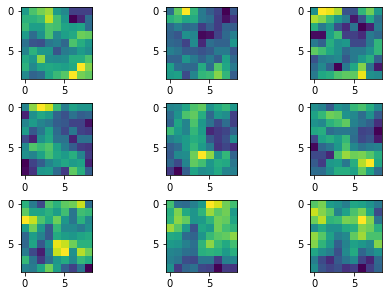

In [21]:
fig, axs = plt.subplots(3, 3, constrained_layout=True)

for i, ax in enumerate(axs.flat):
    ax.imshow(sec_way[i])